### Libraries

In [1]:
%%capture
# Import necessary libraries.
!pip install contractions
import re, string, unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import contractions
from bs4 import BeautifulSoup                 
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    
from nltk.stem import LancasterStemmer, WordNetLemmatizer

color= "Spectral"

### Load Data

In [39]:
data = pd.read_csv("Tweets.csv")

In [40]:
data.shape

(14640, 15)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
data.describe(include='all')

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,1.464000e+04,14640,14640.000000,9178,10522.000000,14640,40,14640,32,14640.000000,14640,1019,14640,9907,9820
unique,NaN,3,NaN,10,NaN,6,3,7701,13,NaN,14427,832,14247,3081,85
top,NaN,negative,NaN,Customer Service Issue,NaN,United,negative,JetBlueNews,Customer Service Issue,NaN,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,9178,NaN,2910,NaN,3822,32,63,12,NaN,6,164,5,157,3744
mean,5.692184e+17,NaN,0.900169,NaN,0.638298,NaN,NaN,NaN,NaN,0.082650,NaN,NaN,NaN,NaN,NaN
std,7.791112e+14,NaN,0.162830,NaN,0.330440,NaN,NaN,NaN,NaN,0.745778,NaN,NaN,NaN,NaN,NaN
min,5.675883e+17,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5.685592e+17,NaN,0.692300,NaN,0.360600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,5.694779e+17,NaN,1.000000,NaN,0.670600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
75%,5.698905e+17,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [6]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Exploratory Data Analysis

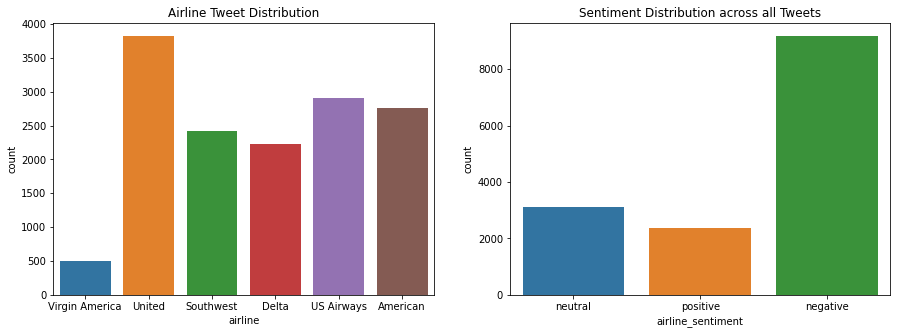

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax=axes[0], x='airline', data=data)
axes[0].set_title('Airline Tweet Distribution')

sns.countplot(ax=axes[1], x='airline_sentiment', data=data)
axes[1].set_title('Sentiment Distribution across all Tweets')

plt.show()

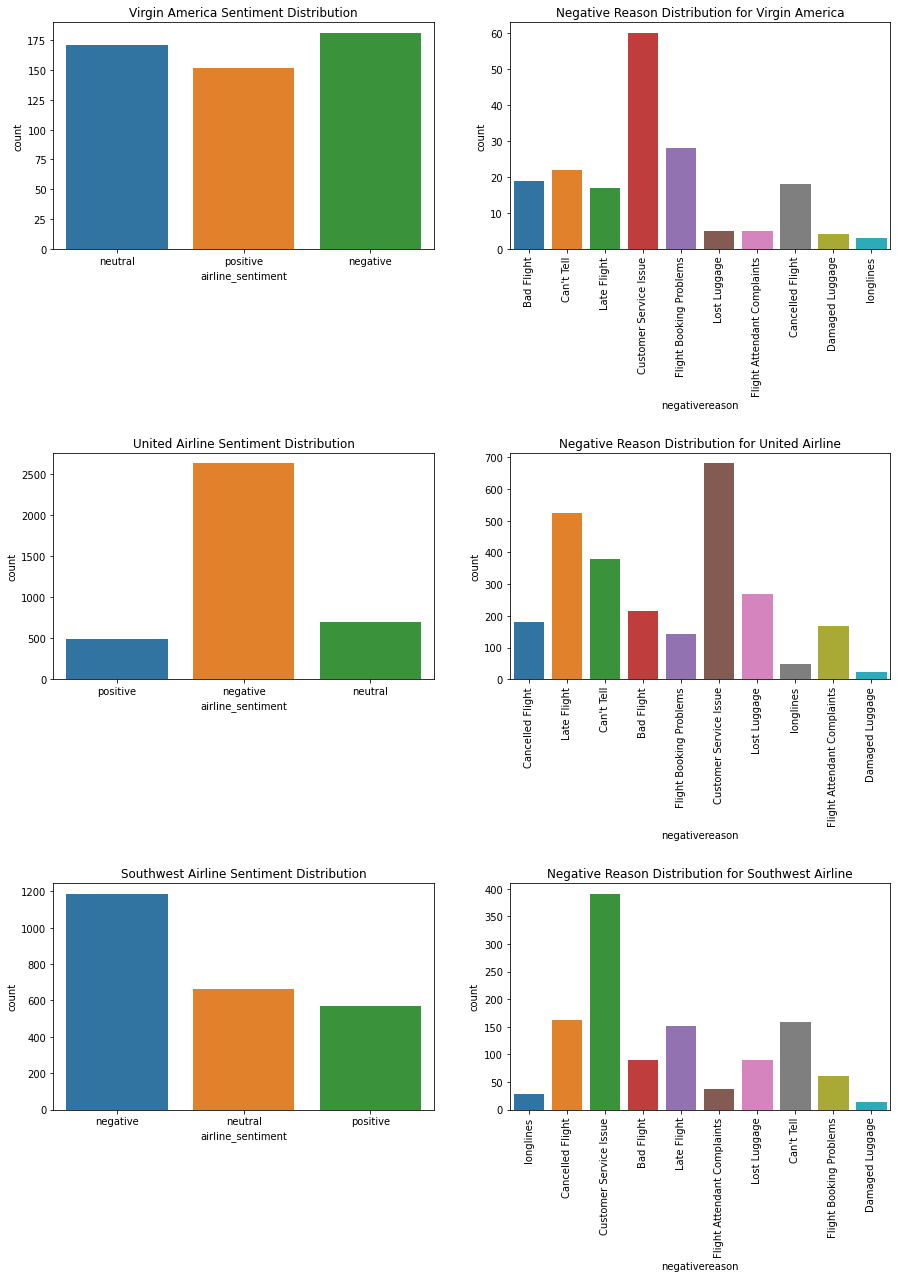

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
sns.countplot(ax=axes[0,0], x='airline_sentiment', data=data[data['airline']=='Virgin America'])
axes[0,0].set_title('Virgin America Sentiment Distribution')
sns.countplot(ax=axes[0,1], x='negativereason', data=data[data['airline']=='Virgin America'])
axes[0,1].set_title('Negative Reason Distribution for Virgin America')
axes[0,1].tick_params(axis='x', rotation=90)

sns.countplot(ax=axes[1,0], x='airline_sentiment', data=data[data['airline']=='United'])
axes[1,0].set_title('United Airline Sentiment Distribution')
sns.countplot(ax=axes[1,1], x='negativereason', data=data[data['airline']=='United'])
axes[1,1].set_title('Negative Reason Distribution for United Airline')
axes[1,1].tick_params(axis='x', rotation=90)

sns.countplot(ax=axes[2,0], x='airline_sentiment', data=data[data['airline']=='Southwest'])
axes[2,0].set_title('Southwest Airline Sentiment Distribution')
sns.countplot(ax=axes[2,1], x='negativereason', data=data[data['airline']=='Southwest'])
axes[2,1].set_title('Negative Reason Distribution for Southwest Airline')
axes[2,1].tick_params(axis='x', rotation=90)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.9)
plt.show()

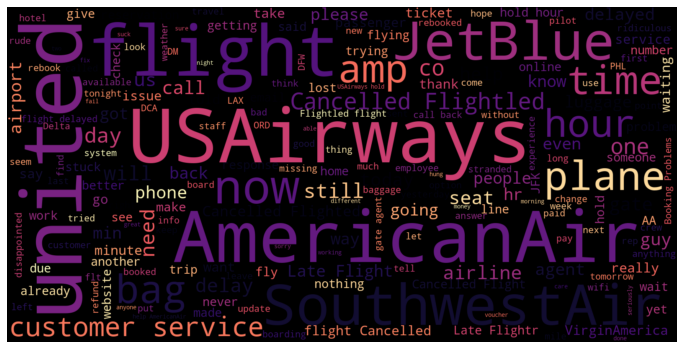

In [42]:
neg_tweets = data[data['airline_sentiment'] == 'negative']
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neg_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

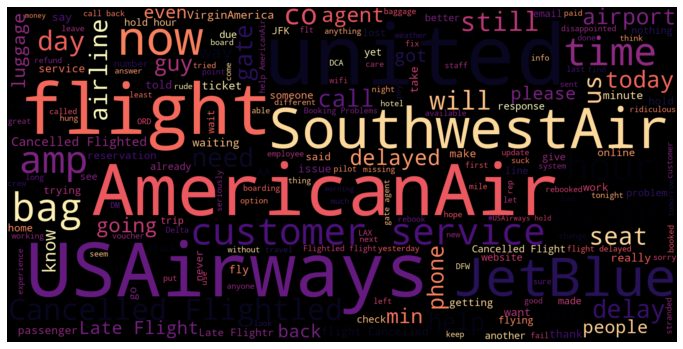

In [43]:
pos_tweets = data[data['airline_sentiment'] == 'positive']
pos_string = []
for t in neg_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

### Understanding Data Columns

In [11]:
to_drop = list(set(list(data.columns)) - set(['airline_sentiment', 'text']))

In [12]:
data.drop(to_drop, axis=1, inplace=True)

In [13]:
data.shape

(14640, 2)

In [14]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


### Data Preparation

In [15]:
#Removing HTML tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")    
    return soup.get_text()
data['text'] = data['text'].apply(strip_html)
data['text']

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [16]:
#Tokenization
data['text'] = data['text'].apply(nltk.word_tokenize)
data['text']

0           [@, VirginAmerica, What, @, dhepburn, said, .]
1        [@, VirginAmerica, plus, you, 've, added, comm...
2        [@, VirginAmerica, I, did, n't, today, ..., Mu...
3        [@, VirginAmerica, it, 's, really, aggressive,...
4        [@, VirginAmerica, and, it, 's, a, really, big...
                               ...                        
14635    [@, AmericanAir, thank, you, we, got, on, a, d...
14636    [@, AmericanAir, leaving, over, 20, minutes, L...
14637    [@, AmericanAir, Please, bring, American, Airl...
14638    [@, AmericanAir, you, have, my, money, ,, you,...
14639    [@, AmericanAir, we, have, 8, ppl, so, we, nee...
Name: text, Length: 14640, dtype: object

In [17]:
#Removing number
def remove_number(tweet):
  cleaned = []
  for i in tweet:
    cleaned.append(re.sub(r'[0-9\.]+', '', i))
  return(cleaned)
data['text'] = data['text'].apply(remove_number)
data['text']

0            [@, VirginAmerica, What, @, dhepburn, said, ]
1        [@, VirginAmerica, plus, you, 've, added, comm...
2        [@, VirginAmerica, I, did, n't, today, , Must,...
3        [@, VirginAmerica, it, 's, really, aggressive,...
4        [@, VirginAmerica, and, it, 's, a, really, big...
                               ...                        
14635    [@, AmericanAir, thank, you, we, got, on, a, d...
14636    [@, AmericanAir, leaving, over, , minutes, Lat...
14637    [@, AmericanAir, Please, bring, American, Airl...
14638    [@, AmericanAir, you, have, my, money, ,, you,...
14639    [@, AmericanAir, we, have, , ppl, so, we, need...
Name: text, Length: 14640, dtype: object

In [18]:
#Removing special character
def remove_special_char(tweet):
  cleaned = []
  for i in tweet:
    cleaned.append(re.sub(r'[^a-zA-Z]', '', i))
  return(cleaned)
data['text'] = data['text'].apply(remove_special_char)
data['text']


0              [, VirginAmerica, What, , dhepburn, said, ]
1        [, VirginAmerica, plus, you, ve, added, commer...
2        [, VirginAmerica, I, did, nt, today, , Must, m...
3        [, VirginAmerica, it, s, really, aggressive, t...
4        [, VirginAmerica, and, it, s, a, really, big, ...
                               ...                        
14635    [, AmericanAir, thank, you, we, got, on, a, di...
14636    [, AmericanAir, leaving, over, , minutes, Late...
14637    [, AmericanAir, Please, bring, American, Airli...
14638    [, AmericanAir, you, have, my, money, , you, c...
14639    [, AmericanAir, we, have, , ppl, so, we, need,...
Name: text, Length: 14640, dtype: object

In [19]:
#removing punctuation
def remove_punctuation(tweet):
  cleaned = []
  for i in tweet:
    cleaned.append(re.sub(r'[.|,|)|(|\|/]',r' ', i))
  return(cleaned)
data['text'] = data['text'].apply(remove_punctuation)
data['text']

0              [, VirginAmerica, What, , dhepburn, said, ]
1        [, VirginAmerica, plus, you, ve, added, commer...
2        [, VirginAmerica, I, did, nt, today, , Must, m...
3        [, VirginAmerica, it, s, really, aggressive, t...
4        [, VirginAmerica, and, it, s, a, really, big, ...
                               ...                        
14635    [, AmericanAir, thank, you, we, got, on, a, di...
14636    [, AmericanAir, leaving, over, , minutes, Late...
14637    [, AmericanAir, Please, bring, American, Airli...
14638    [, AmericanAir, you, have, my, money, , you, c...
14639    [, AmericanAir, we, have, , ppl, so, we, need,...
Name: text, Length: 14640, dtype: object

In [20]:
#removing stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)        # Append processed words to new list.
    return new_words
data['text'] = data['text'].apply(remove_stopwords)
data['text']

0              [, VirginAmerica, What, , dhepburn, said, ]
1        [, VirginAmerica, plus, added, commercials, ex...
2        [, VirginAmerica, I, nt, today, , Must, mean, ...
3        [, VirginAmerica, really, aggressive, blast, o...
4               [, VirginAmerica, really, big, bad, thing]
                               ...                        
14635    [, AmericanAir, thank, got, different, flight,...
14636    [, AmericanAir, leaving, , minutes, Late, Flig...
14637    [, AmericanAir, Please, bring, American, Airli...
14638    [, AmericanAir, money, , change, flight, , nt,...
14639    [, AmericanAir, , ppl, need, , know, many, sea...
Name: text, Length: 14640, dtype: object

In [21]:
#conver to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words
data['text'] = data['text'].apply(to_lowercase)
data['text']

0              [, virginamerica, what, , dhepburn, said, ]
1        [, virginamerica, plus, added, commercials, ex...
2        [, virginamerica, i, nt, today, , must, mean, ...
3        [, virginamerica, really, aggressive, blast, o...
4               [, virginamerica, really, big, bad, thing]
                               ...                        
14635    [, americanair, thank, got, different, flight,...
14636    [, americanair, leaving, , minutes, late, flig...
14637    [, americanair, please, bring, american, airli...
14638    [, americanair, money, , change, flight, , nt,...
14639    [, americanair, , ppl, need, , know, many, sea...
Name: text, Length: 14640, dtype: object

In [22]:
#lemmatize word
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas
data['text'] = data['text'].apply(lemmatize_verbs)
data['text']

0               [, virginamerica, what, , dhepburn, say, ]
1        [, virginamerica, plus, add, commercials, expe...
2        [, virginamerica, i, nt, today, , must, mean, ...
3        [, virginamerica, really, aggressive, blast, o...
4               [, virginamerica, really, big, bad, thing]
                               ...                        
14635    [, americanair, thank, get, different, flight,...
14636    [, americanair, leave, , minutes, late, flight...
14637    [, americanair, please, bring, american, airli...
14638    [, americanair, money, , change, flight, , nt,...
14639    [, americanair, , ppl, need, , know, many, sea...
Name: text, Length: 14640, dtype: object

In [23]:
#join to single string
data['text'] = data['text'].str.join(" ")

In [24]:
data.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus add commercials experience...
2,neutral,virginamerica i nt today must mean i need ta...
3,negative,virginamerica really aggressive blast obnoxio...
4,negative,virginamerica really big bad thing


### Vectorization and Modelling

In [25]:
#label encoding
le = LabelEncoder()
le.fit(data['airline_sentiment'])
le.classes_
data['airline_sentiment'] = le.transform(data['airline_sentiment'])
data['airline_sentiment'].value_counts()

0    9178
1    3099
2    2363
Name: airline_sentiment, dtype: int64

In [26]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [27]:
#data assignment
X = data.drop(['airline_sentiment'], axis=1)
y = data['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

In [28]:
#TFID
tfidf_vect = TfidfVectorizer()
X_train_tf = tfidf_vect.fit_transform(X_train['text'])
X_test_tf = tfidf_vect.transform(X_test['text'])

In [29]:
#Count Vectorizer
cv = CountVectorizer()  
X_train_cv = cv.fit_transform(X_train['text'])
X_test_cv = cv.transform(X_test['text'])

### Random Forest with TFID

In [31]:
random_forest = RandomForestClassifier(random_state=42,n_estimators=80)
model = random_forest.fit(X_train_tf, y_train)
pred = model.predict(X_test_tf)

In [32]:
print('Confusion Matrix =\n',confusion_matrix(y_test, pred))
print('Classification Report =\n',classification_report(y_test, pred))

Confusion Matrix =
 [[1735   70   31]
 [ 328  254   38]
 [ 160   68  244]]
Classification Report =
               precision    recall  f1-score   support

           0       0.78      0.94      0.85      1836
           1       0.65      0.41      0.50       620
           2       0.78      0.52      0.62       472

    accuracy                           0.76      2928
   macro avg       0.74      0.62      0.66      2928
weighted avg       0.75      0.76      0.74      2928



In [46]:
model.feature_importances_

array([1.34082689e-03, 1.20805428e-09, 0.00000000e+00, ...,
       4.67702156e-07, 2.72245139e-06, 1.65693269e-05])

In [ ]:
tfidf_vect.get_feature_names()

### Random Forest with Count Vectorizer

In [35]:
random_forest_ = RandomForestClassifier(random_state=42,n_estimators=80)
model_ = random_forest_.fit(X_train_cv, y_train)
pred_ = model_.predict(X_test_cv)

In [36]:
print('Confusion Matrix =\n',confusion_matrix(y_test, pred_))
print('Classification Report =\n',classification_report(y_test, pred_))

Confusion Matrix =
 [[1688  103   45]
 [ 252  330   38]
 [ 131   82  259]]
Classification Report =
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      1836
           1       0.64      0.53      0.58       620
           2       0.76      0.55      0.64       472

    accuracy                           0.78      2928
   macro avg       0.74      0.67      0.69      2928
weighted avg       0.77      0.78      0.77      2928



### Comments

Sentiment Analysis is a powerful use to gain insights on the emotion behind a written text. The Data Preparation has proven to be the critical part of this Assignment as any text contaminat could result to a bias analysis. It was evident that the Word Cloud from the unclean text didnt potray key information around positive and negative sentiment as they were lots of noise in the data.

The TDIF and Count Vectorizer produced similar results when trained with Random Forest Analysis. Also I decided to use lemmatization for this assignment as the produced meaningful context in creating tokens.